[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.9.7. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

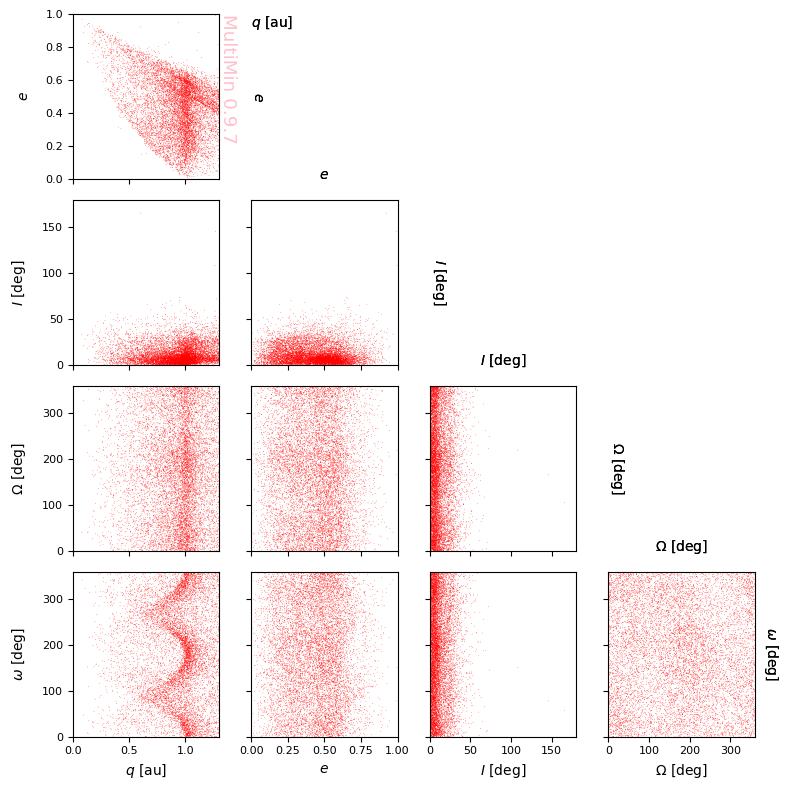

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

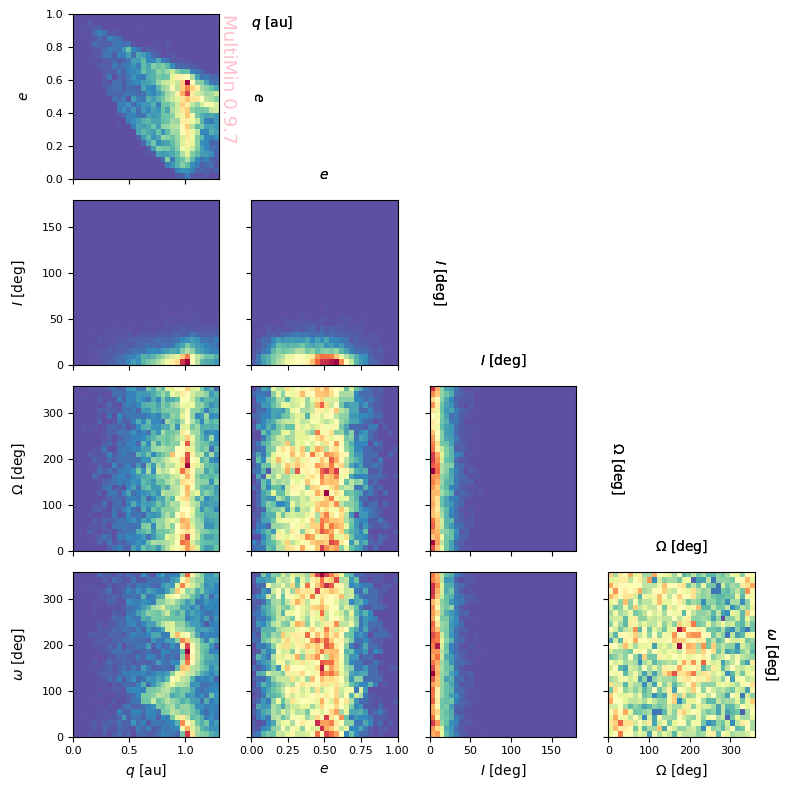

In [5]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

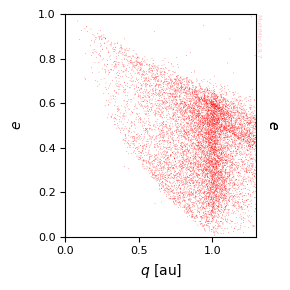

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.30607401035658505
Elapsed time since last call: 118.139 ms
-log(L)/N = -0.5514435474217224


And check the fit result:

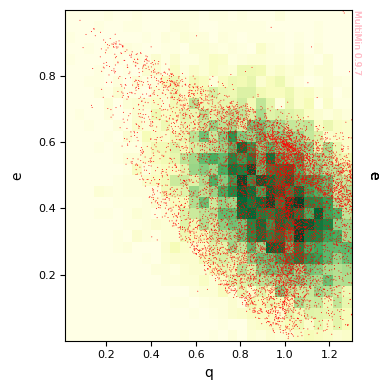

In [9]:
# properties: list of names or dict like DensityPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.mog.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.968939,0.414245,0.262177,0.186908,-0.420771


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data()
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.24521246356017237


Elapsed time since last call: 22.5817 s
-log(L)/N = -0.7304869092376379


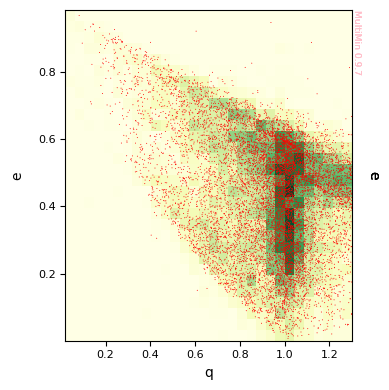

In [12]:
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.mog.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

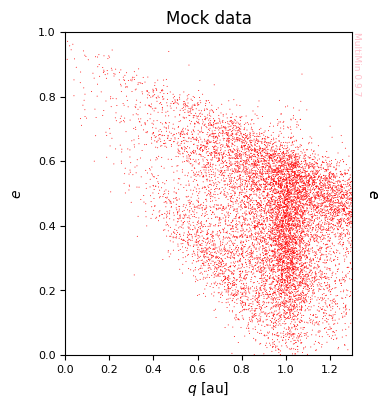

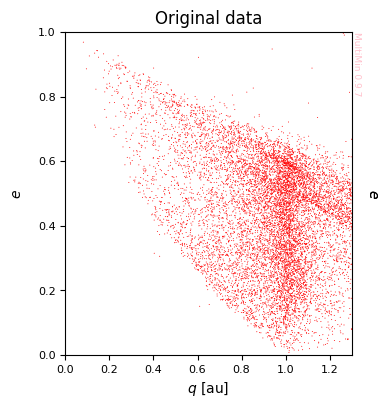

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
3,0.364972,0.952776,0.347514,0.206394,0.145928,-0.455725
2,0.313535,1.134342,0.506883,0.368889,0.119963,-0.863109
5,0.176384,1.007633,0.334682,0.047169,0.160143,-0.028486
1,0.081435,0.688836,0.272652,0.185815,0.149070,-0.941803
4,0.063674,0.810647,0.671415,0.346358,0.127479,-0.985089


In [16]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.688836
    mu1_e = 0.272652
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.034527, -0.026087], [-0.026087, 0.022222]]
    Z1 = 0.966197
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 1.134342
    mu2_e = 0.506883
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.136079, -0.038195], [-0.038195, 0.014391]]
    Z2 = 0.672256
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.952776
    mu3_e = 0.347514
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.042598, -0.013726], [-0.013726, 0.021295]]
    Z3 = 0.947796
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 0.810647
    mu4_e = 0.671415
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.119964, -0.043495], [-0.043495, 0.016251]]
    Z4 = 0.911393
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.007633
    mu5_e = 0.334682
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.002225, -0.000215], [-0.000215, 0.025646]]
   

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 131.51761959986547
-log(L)/N = 3.455755790487446


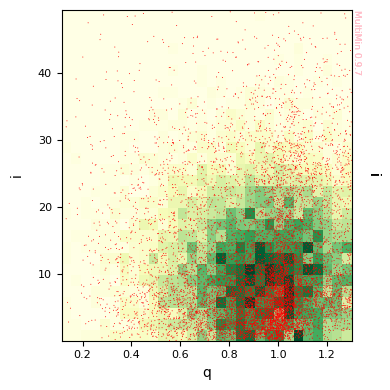

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 134.32749792798376
-log(L)/N = 3.2829939088383595


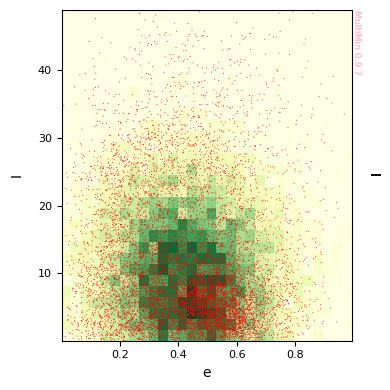

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

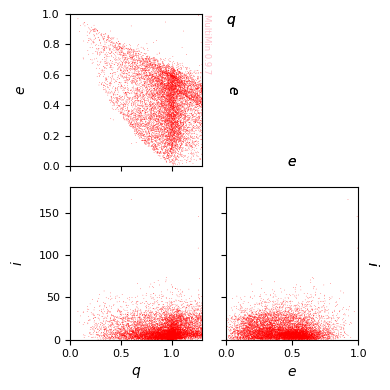

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 144.74610159151013


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -1.3622110815393227


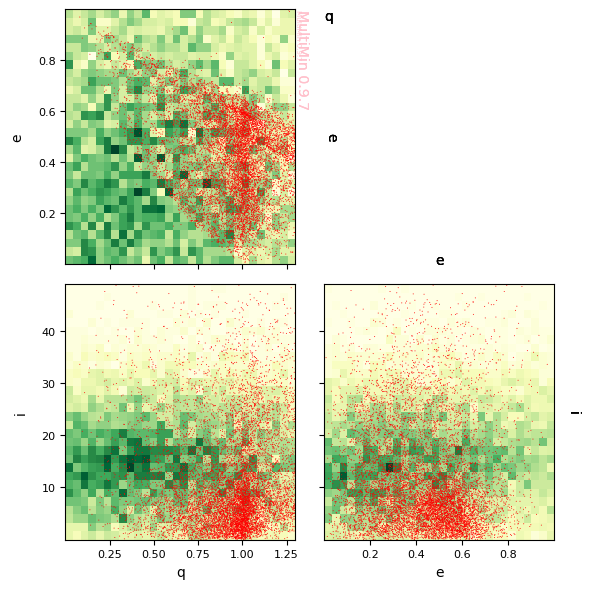

In [21]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 144.74610053001672


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -2.395733140270412


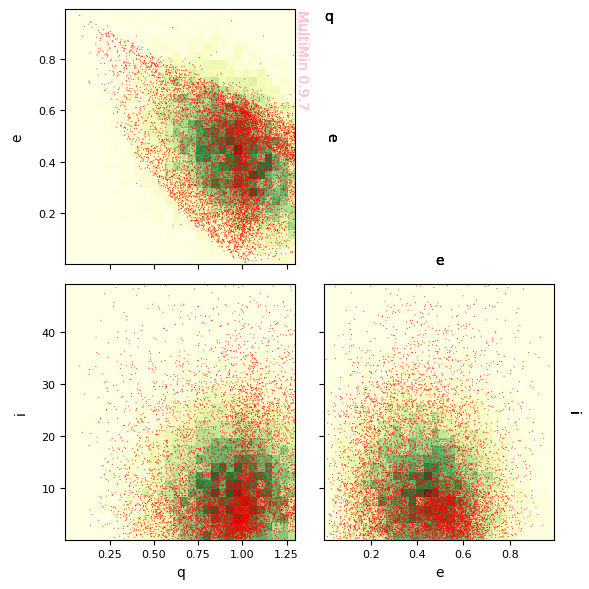

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 335.60713464354376


Minimizing: 0it [00:00, ?it/s]

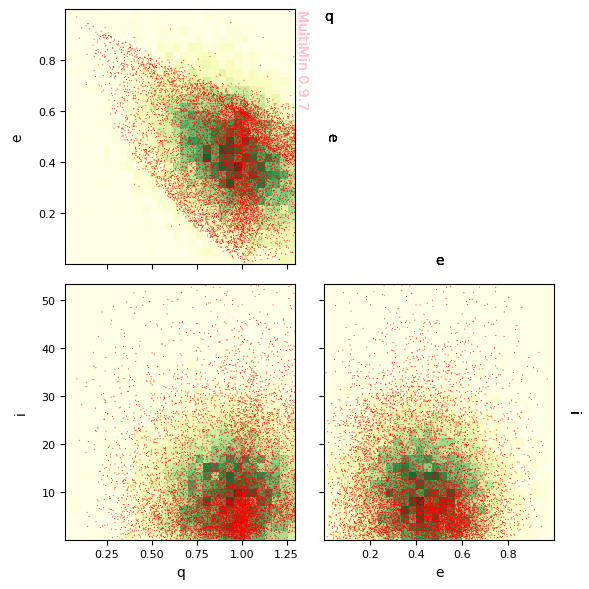

In [23]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

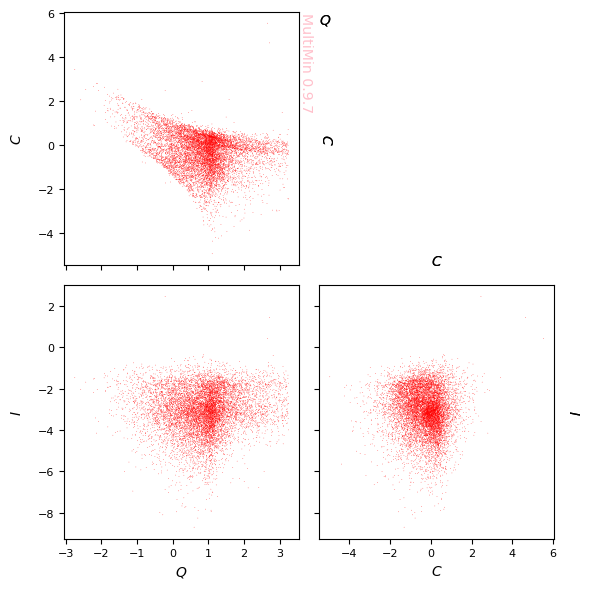

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

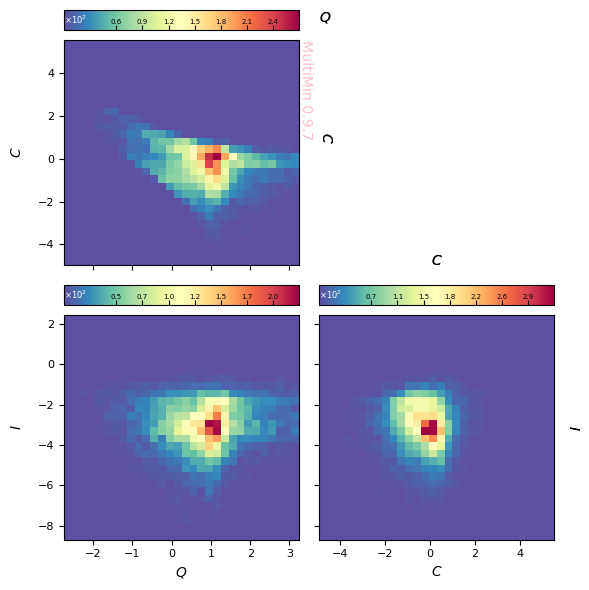

In [26]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.925883364903346


The fitter holds an initial MoG that will be optimized:

In [28]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 148.562 ms
-log(L)/N = 3.946843656496681


Inspect the fitted MoG:

In [30]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8600072377158567, -0.33342419465766215, -3.06293279473333]]
    Standard deviations (σ): [[0.8423644153348271, 0.8583318587766142, 1.0702876161572623]]
    Correlation coefficients (ρ): [[-0.3072869441670377, 0.0554024729281024, -0.07250119260156263]]

    Covariant matrices (Σ): 
        [[[0.709577808222385, -0.22217713054387725, 0.0499493295153875], [-0.22217713054387725, 0.7367335797909176, -0.06660408762532227], [0.0499493295153875, -0.06660408762532227, 1.1455155812995952]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8600072377158567, -0.33342419465766215, -3.06293279473333, 0.709577808222385, -0.22217713054387725, 0.0499493295153875, 0.7367335797909176, -0.06660408762532227, 1.1455155812995952]
        With std. and correlations

Plot the fit result (fitted sample + data scatter):

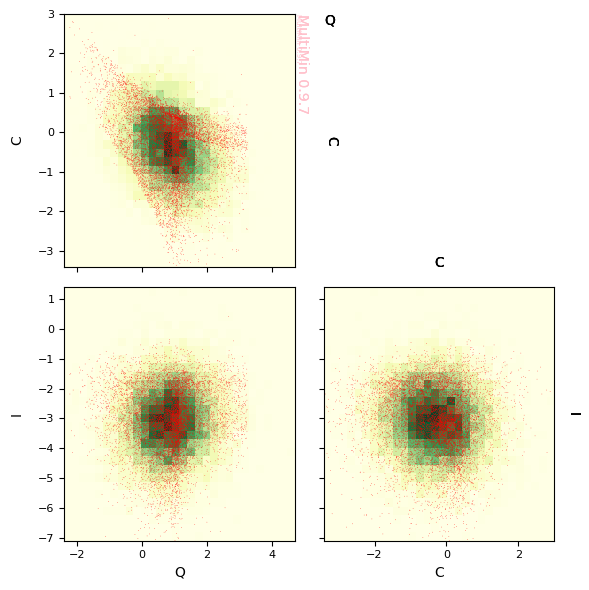

In [31]:
properties=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.946843656496681
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8600072377158567, -0.33342419465766215, -3.06293279473333]]
    Standard deviations (σ): [[0.8423644153348271, 0.8583318587766142, 1.0702876161572623]]
    Correlation coefficients (ρ): [[-0.3072869441670377, 0.0554024729281024, -0.07250119260156263]]

    Covariant matrices (Σ): 
        [[[0.709577808222385, -0.22217713054387725, 0.0499493295153875], [-0.22217713054387725, 0.7367335797909176, -0.06660408762532227], [0.0499493295153875, -0.06660408762532227, 1.1455155812995952]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8600072377158567, -0.33342419465766215, -

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.925883364903346


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 2.0373 s
-log(L)/N = 3.834211779597852
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.39444934130988873, 0.6055506586901113]
    Number of variables: 3
    Averages (μ): [[1.0342562846197259, 0.2630086054229549, -3.33933671294988], [0.7360731755960743, -0.7055534384329396, -2.88896845420955]]
    Standard deviations (σ): [[0.9943820068552038, 0.4897567742526862, 1.0950888718041487], [0.7014797417231329, 0.8290683457475018, 1.0159622355145217]]
    Correlation coefficients (ρ): [[-0.7620495122972912, 0.09358618652150152, 0.07573760323847045], [-0.4106294711037707, 0.08515010463073058, 0.04276190173696559]]

    Covariant matrices (Σ): 
        [[[0.9887955755573826, -0.3711221696802525, 0.10190943031147517], [-0.3711221696802525, 0.23986169792639664, 0.04062013617782403], [0.10190943031147517, 0.04062013617782403, 1.1992196371492831]], [[0.4920738280479532, -0.23881169054503076, 0.06068451486527346], [-0.2388

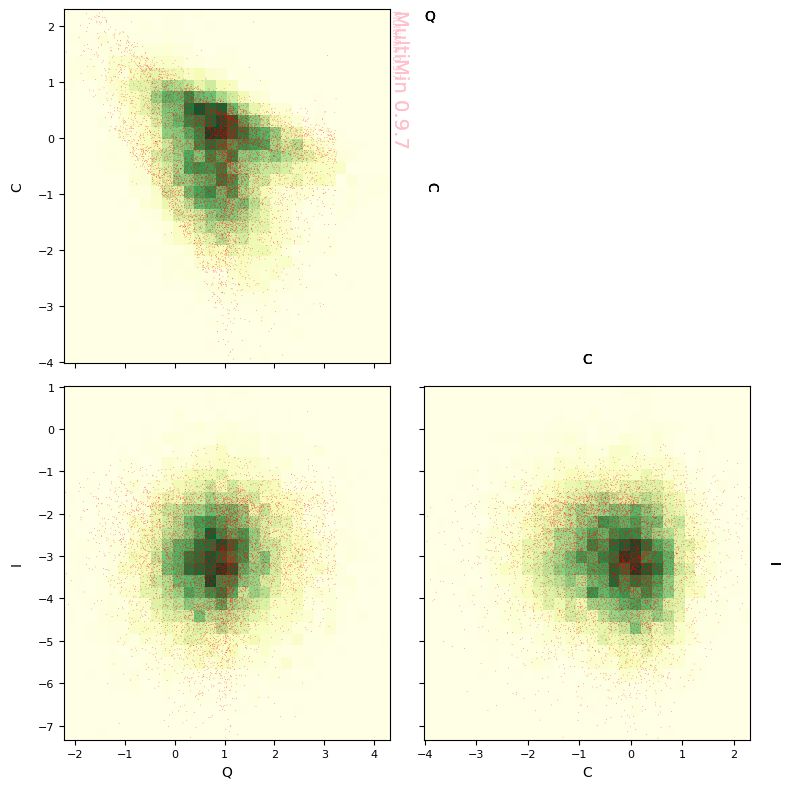

In [34]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.925883364903346


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 2.80587 s
-log(L)/N = 3.813250141199667
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.33220197919577005, 0.6677980208042299]
    Number of variables: 3
    Averages (μ): [[1.3193656293112268, 0.1258533482081581, -3.464042957177191], [0.6202122822515657, -0.5458479788177847, -2.869374365371436]]
    Standard deviations (σ): [[0.7672075264103837, 0.347004669628954, 1.0658682561616233], [0.7760196102247662, 0.9418505881123401, 1.012211108345514]]
    Correlation coefficients (ρ): [[-0.5726723372429747, 0.38246740929589196, -0.12349044048702261], [-0.5565346479680564, 0.059494631929525754, 0.06459960118444363]]

    Covariant matrices (Σ): 
        [[[0.5886073885807396, -0.15245946061434323, 0.3127597209281923], [-0.15245946061434323, 0.1204122407442995, -0.04567433017548829], [0.3127597209281923, -0.04567433017548829, 1.1360751394930197]], [[0.602206435453398, -0.4067681278832967, 0.046732775754813626], [-0.4

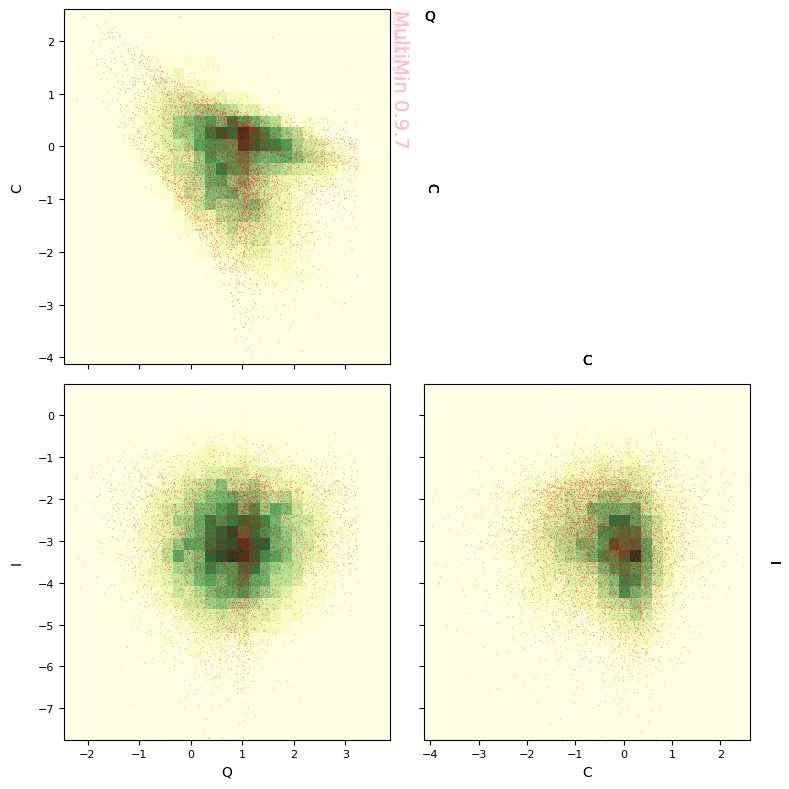

In [35]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 13.925883364903346


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 12.7544 s
-log(L)/N = 3.692893883436218
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.24027350359347205, 0.2525377900869588, 0.12939658711131288, 0.23955086076227267, 0.1382412584459836]
    Number of variables: 3
    Averages (μ): [[0.9870666620036141, -0.6297411787455215, -3.46106656485579], [0.9121010141606042, -0.691577802436996, -2.2998337076813593], [0.5354179021339448, 0.5658844151277153, -3.740431185127838], [1.3498062762257268, 0.07468433086615048, -3.186158971194025], [-0.05000569604907088, -0.6413892431653582, -2.9749310082570806]]
    Standard deviations (σ): [[0.31466584795889646, 0.6925176793316822, 1.1712312179906246], [0.8347022905222417, 0.7016129418011606, 0.6236593901562023], [0.6987896785419343, 0.403786020583847, 1.1838709440551354], [0.8600975574310131, 0.29787941696217296, 0.7336107290451381], [0.7620332980730947, 1.3255189772994942, 1.0724535632454104]]
    Correlation coefficients (

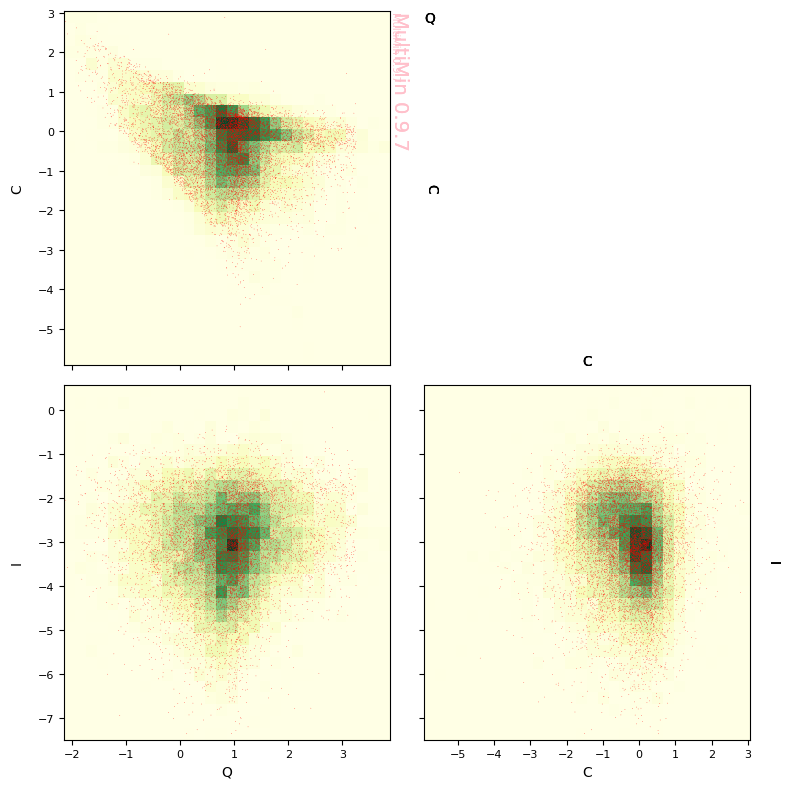

In [36]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

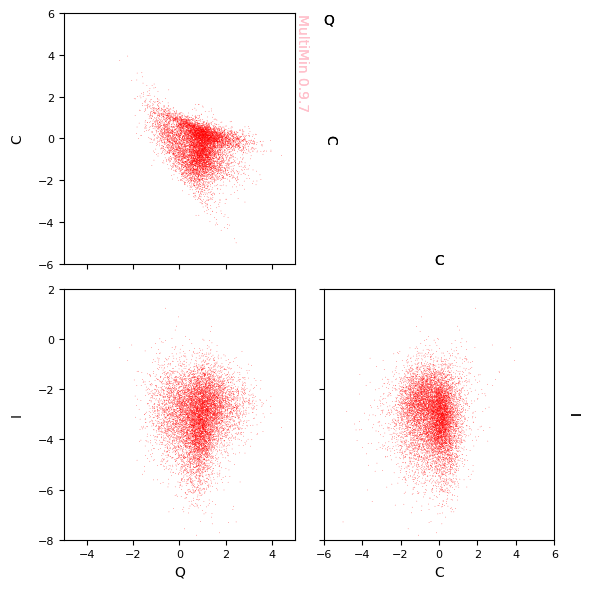

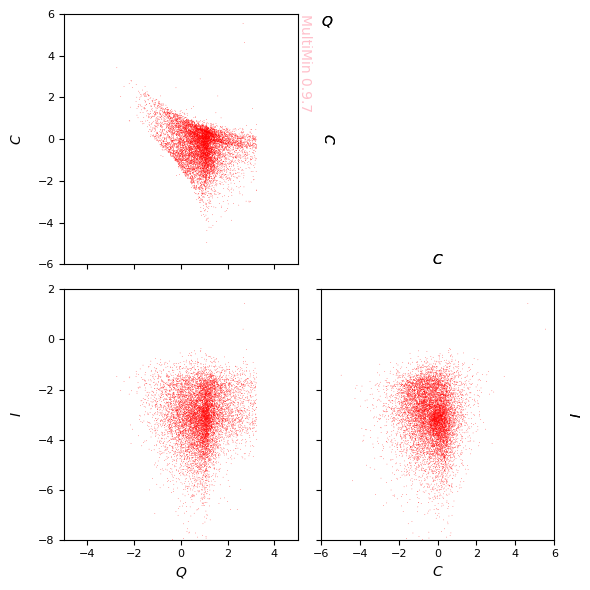

In [37]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

We can also check the original distribution:

In [38]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

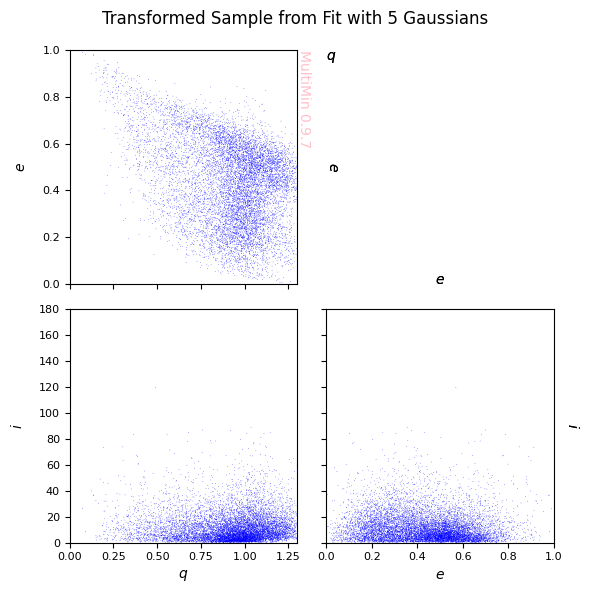

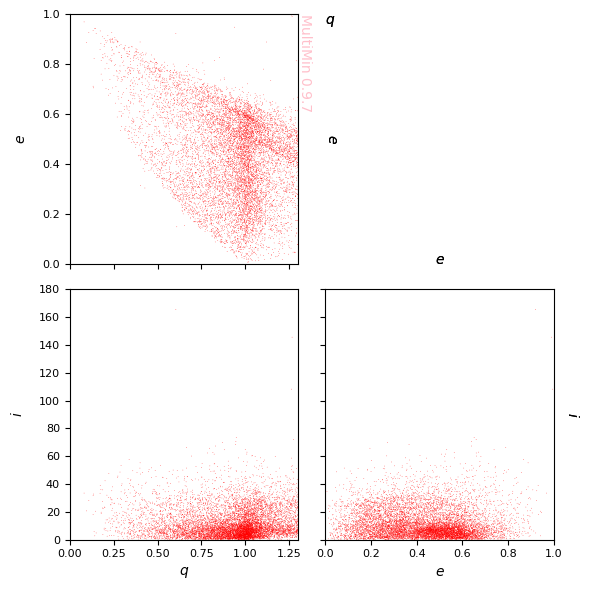

In [39]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.scatter_plot(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.scatter_plot(data_neas_qei,**sargs)

In [40]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 0.987067
    mu1_e = -0.629741
    mu1_i = -3.461067
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.099015, 0.001283, 0.116568], [0.001283, 0.479581, -0.017241], [0.116568, -0.017241, 1.371783]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 0.912101
    mu2_e = -0.691578
    mu2_i = -2.299834
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.696728, -0.281647, 0.055728], [-0.281647, 0.492261, 0.014024], [0.055728, 0.014024, 0.388951]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 0.535418
    mu3_e = 0.565884
    mu3_i = -3.740431
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.488307, -0.247025, -0.175027], [-0.247025, 0.163043, 0.141067], [-0.175027, 0.141067, 1.40155]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = 1.349806
    mu4_e = 0.074684
    mu4_i = -3.186159
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.739768, -0.12058, 0.18707], [-0.12058, 0.088732, 0.02925], [0.18707, 0.02925, 0.538185]]
    n4 = Util.nmd(X, mu4, 

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga